In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics
import yfinance as yf

plt.style.use('fivethirtyeight')

In [61]:
portfolio = yf.download(tickers = 'AOA VNQ RWX IEF IAU', start="2008-12-01", end="2020-05-01") #Past 20 days
#target_volatility = 0.05
target_volatility = 0.08
#target_volatility = 0.1
table = portfolio['Adj Close']
table.head()

[*********************100%***********************]  5 of 5 completed


,AOA,IAU,IEF,RWX,VNQ
Date,,,,,
2008-12-01,16.619623,7.579,73.482864,12.621934,15.772701
2008-12-02,17.057772,7.702,73.868347,13.138089,17.867990
2008-12-03,16.959562,7.619,73.983932,13.052951,18.869814
2008-12-04,16.634726,7.556,74.446518,12.605967,18.350576
2008-12-05,17.246630,7.467,73.660233,12.637894,20.293144


In [3]:
table.index.weekday

Int64Index([2, 4, 0, 1, 2, 3, 4, 0, 1, 2,
            ...
            4, 0, 1, 2, 3, 4, 0, 1, 2, 3],
           dtype='int64', name='Date', length=2852)

Text(0, 0.5, 'price in $')

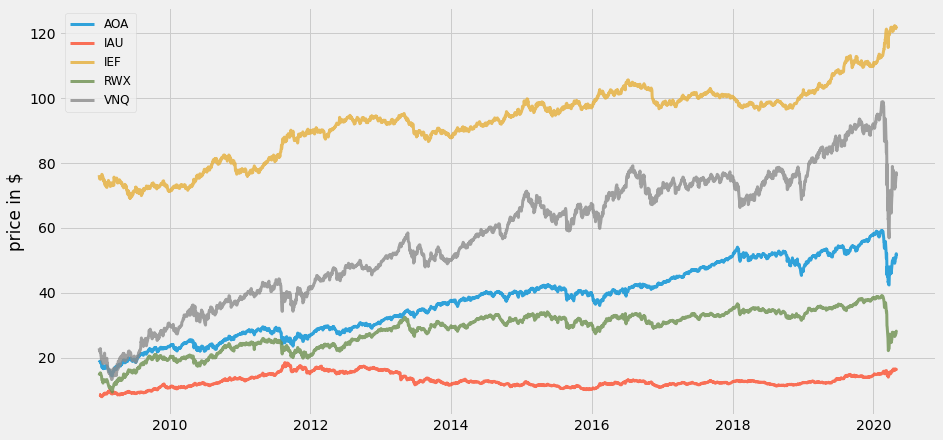

In [62]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

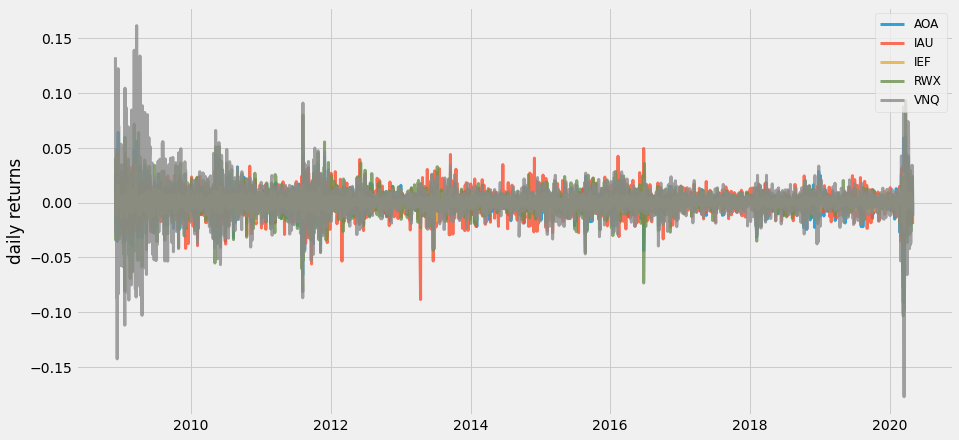

In [21]:
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [11]:
#AOA80% VNQ6% RWX4% IEF6% IAU4%
returns['AOA']
#table['AOA']

Date
2008-12-31         NaN
2009-01-02    0.015586
2009-01-05    0.004443
2009-01-06   -0.001206
2009-01-07   -0.018116
                ...   
2020-04-24    0.007624
2020-04-27    0.012744
2020-04-28    0.000000
2020-04-29    0.023004
2020-04-30   -0.011916
Name: AOA, Length: 2852, dtype: float64

In [62]:
i = 22 #2008/12/31
etf = np.array(['AOA','VNQ','RWX','IEF','IAU'])
weights = np.array([0.8,0.06,0.04,0.06,0.04])
nextRebalanceMonth = 4
date = []
index_return = []
all_return = []
count = 0
monday = 0
while i<len(table):
    #control every Monday
    if table.index.weekday[i]==0:
        monday += 1
        #rebalance in first Monday of each Q
        if table.index.month[i]==nextRebalanceMonth:
            if nextRebalanceMonth==10:
                nextRebalanceMonth=1
            else:
                nextRebalanceMonth=nextRebalanceMonth+3
            weights = np.array([0.8,0.06,0.04,0.06,0.04])
        #volatility control
        if i>20:
            price = table[i-21:i-1].copy()
            log_returns = []
            for e in etf:
                temp = []
                for j in range(1,len(price)):
                    temp.append(math.log(price[e][j])-math.log(price[e][j-1]))
                log_returns.append(pd.DataFrame(temp))
            log_returns = pd.concat(log_returns,axis=1)
            #mean_returns = log_returns.mean()
            cov_matrix = log_returns.cov()
            std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
            if std > target_volatility:
                weights = weights*target_volatility/std
                print("control",weights)
                count += 1
    #i<=19, do not control
    #Calculate weight*return everyday as index performance
    date.append(table.index[i])
    if i==22:
        index_return.append(100)
    elif i>22:
        daily_return = returns['AOA'][i]*weights[0]+returns['VNQ'][i]*weights[1]+returns['RWX'][i]*weights[2]+returns['IEF'][i]*weights[3]+returns['IAU'][i]*weights[4]
        all_return.append(daily_return)
        temp = index_return[i-23]*(1+daily_return)
        index_return.append(temp)
    i += 1
print(count, monday)

control [0.1716113  0.01287085 0.00858057 0.01287085 0.00858057]
control [0.16363964 0.01227297 0.00818198 0.01227297 0.00818198]
control [0.17144279 0.01285821 0.00857214 0.01285821 0.00857214]
control [0.36503579 0.02737768 0.01825179 0.02737768 0.01825179]
control [0.32831996 0.024624   0.016416   0.024624   0.016416  ]
control [0.31079049 0.02330929 0.01553952 0.02330929 0.01553952]
control [0.38807348 0.02910551 0.01940367 0.02910551 0.01940367]
control [0.37500701 0.02812553 0.01875035 0.02812553 0.01875035]
control [0.37326552 0.02799491 0.01866328 0.02799491 0.01866328]
control [0.35804139 0.0268531  0.01790207 0.0268531  0.01790207]
control [0.34424648 0.02581849 0.01721232 0.02581849 0.01721232]
control [0.33071798 0.02480385 0.0165359  0.02480385 0.0165359 ]
control [0.32215931 0.02416195 0.01610797 0.02416195 0.01610797]
control [0.74677781 0.05600834 0.03733889 0.05600834 0.03733889]
control [0.72262155 0.05419662 0.03613108 0.05419662 0.03613108]
control [0.52785073 0.039

Text(0, 0.5, 'Volatility Control Index')

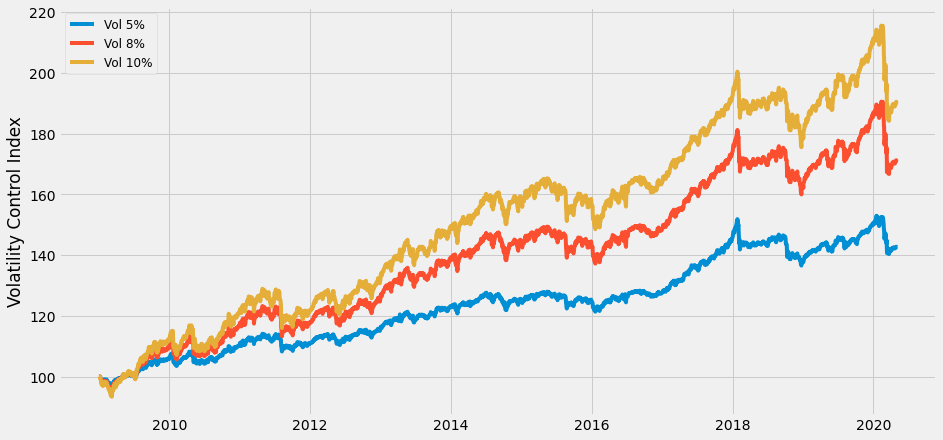

In [46]:
plt.figure(figsize=(14, 7))
plt.plot(date,index_return,label='Vol 5%')
plt.plot(date,index_return2,label='Vol 8%')
plt.plot(date,index_return3,label='Vol 10%')
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Volatility Control Index')

In [54]:
#Annual Return
math.pow(index_return[len(index_return)-1]/100,1/11.4)

1.0481970938827503

In [56]:
#Max Dropdown
a = index_return[2700:2852]
min(a)/max(index_return)

0.8751517152624279

In [57]:
#Annual Volatility
statistics.stdev(all_return)*np.sqrt(252)

0.07068896603332746

In [58]:
#Return/ Risk
(math.pow(index_return[len(index_return3)-1]/100,1/11.4)-1)/(statistics.stdev(all_return)*np.sqrt(252))

0.6818191945264411